# 학습 목표 : 캐글 무작정! 따라해보기
1. 데이터를 깊게 탐색하는 EDA 과정을 통해 불필요한 피처를 골라내거나 적절하게 피처를 수정하는 등의 피처 엔지니어링을 진행함으로써 데이터를 정제하는 것이 매우 중요
2. 직접 다양한 하이퍼 파라미터를 튜닝하며 최적의 조합을 찾아보기 
3. 시도해볼 수 있는 방법
    - 기존에 있는 데이터의 피처를 모델을 보다 잘 표현할 수 있는 형태로 처리하기 (피처 엔지니어링)
    - LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝하기
    - 다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기
    - Baseline 커널에서 활용했던 블렌딩 방법 활용하기

### 프로젝트 루브릭 
- 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?
- 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?
- 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?

In [1]:
# 시각화 나타내는 코드 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings("ignore")


# 필요한 라이브러리 import
import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# 알맞은 파일 경로 
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


In [3]:
# 데이터 불러오기 
# sub data에는 price가 없으므로 20으로 컬럼 1개가 적음
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

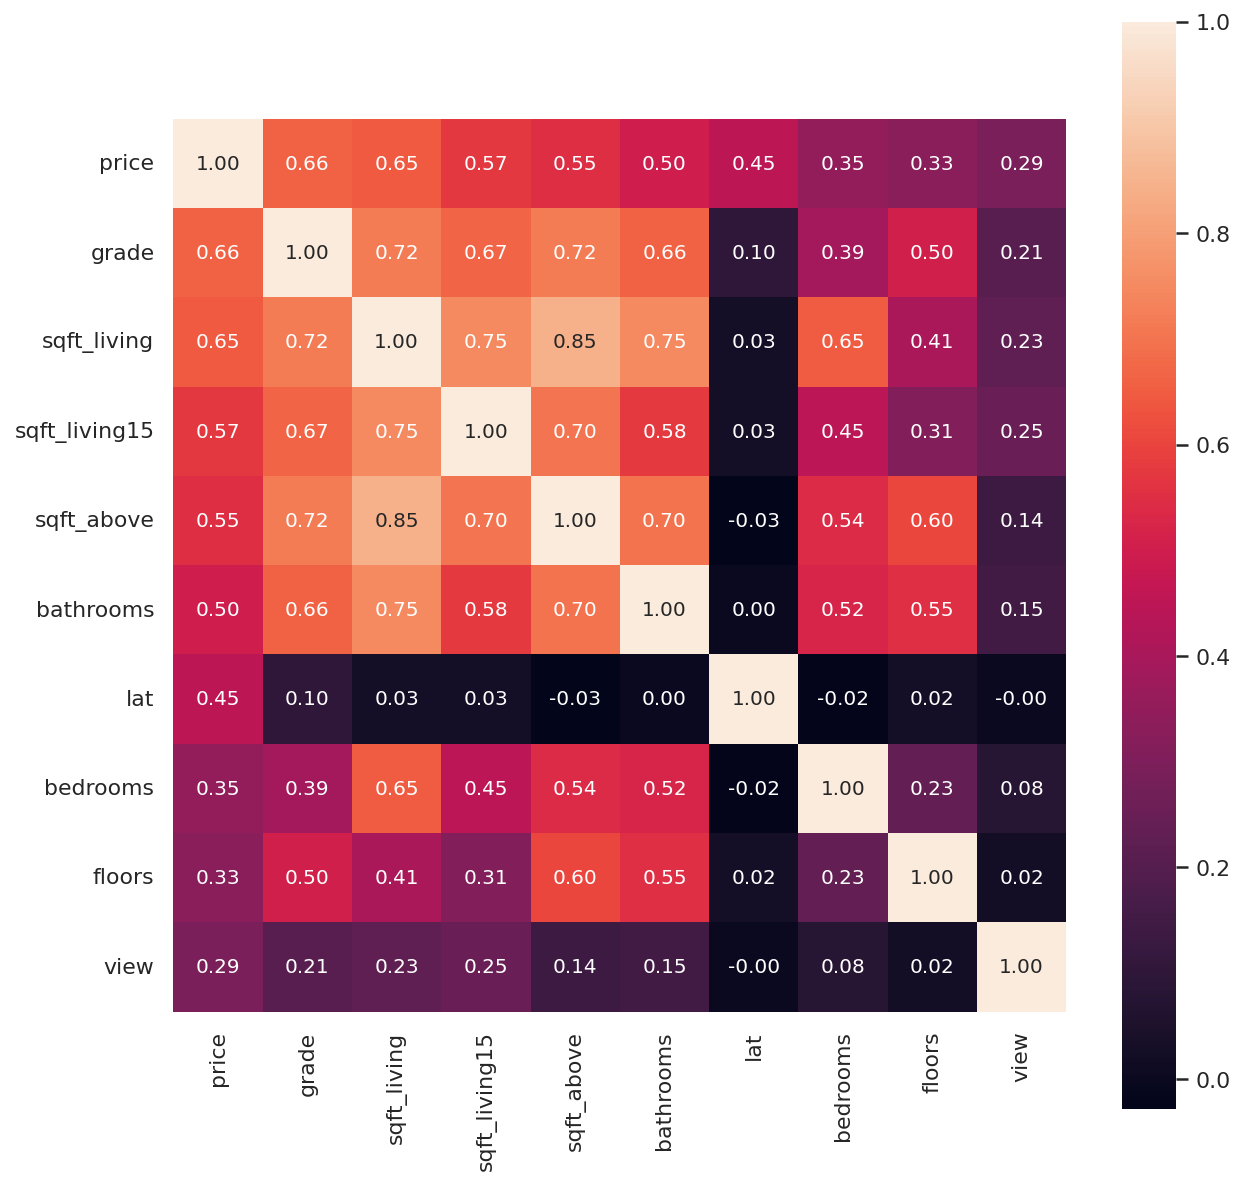

In [4]:
# correlation이 높은 상위 10개의 heatmap
import scipy as sp

cor_abs = abs(data.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(data[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 10} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

### 집값 price와 가장 높은 상관관계를 가지는 컬럼은 *grade* 이고 가장 낮은 상관관계를 가지는 컬럼은 *view*

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. **bedrooms : 침실의 수**
5. **bathrooms : 침실당 화장실 개수**
6. **sqft_living : 주거 공간의 평방 피트** 
7. sqft_lot : 부지의 평방 피트
8. **floors : 집의 층수**
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. **view : 집이 얼마나 좋아 보이는지의 정도**
11. condition : 집의 전반적인 상태
12. **grade : King County grading 시스템 기준으로 매긴 집의 등급**
13. **sqft_above : 지하실을 제외한 평방 피트**
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. **lat : 위도**
19. long : 경도
20. **sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트** 
21. sqft_lot15 : 근처 15가구의 부지, 평방 피트

In [5]:
# price에 대한 다른 변수들의 상관관계
cor_data = data.corr()
cor_data["price"].sort_values(ascending = False)

price            1.000000
sqft_living      0.702899
grade            0.667211
sqft_above       0.608577
sqft_living15    0.586419
bathrooms        0.525479
view             0.400806
bedrooms         0.323672
sqft_basement    0.322218
lat              0.301604
waterfront       0.265738
floors           0.262588
yr_renovated     0.140808
sqft_lot         0.096793
sqft_lot15       0.086384
yr_built         0.047290
condition        0.039740
long             0.023547
id               0.020899
zipcode         -0.051498
Name: price, dtype: float64

### 위의 상관관계의 경우 heatmap 결과와 조금 다르게 제일 높은 상관관계는 sqft_living으로 나옴, 그래도 2위는 grade로 나옴
- 평수에 따라 높은 집값은 당연한 결과라는 생각이 듦 
- zipcode는 심지어 - 음의 상관관계로 나옴 

In [6]:
# 가장 많은 등급은 7등급인 것을 볼 수 있다. 
data['grade'].value_counts()

7     6228
8     4207
9     1855
6     1406
10     781
11     288
5      174
12      61
4       23
13       9
3        2
1        1
Name: grade, dtype: int64

<AxesSubplot:xlabel='grade', ylabel='price'>

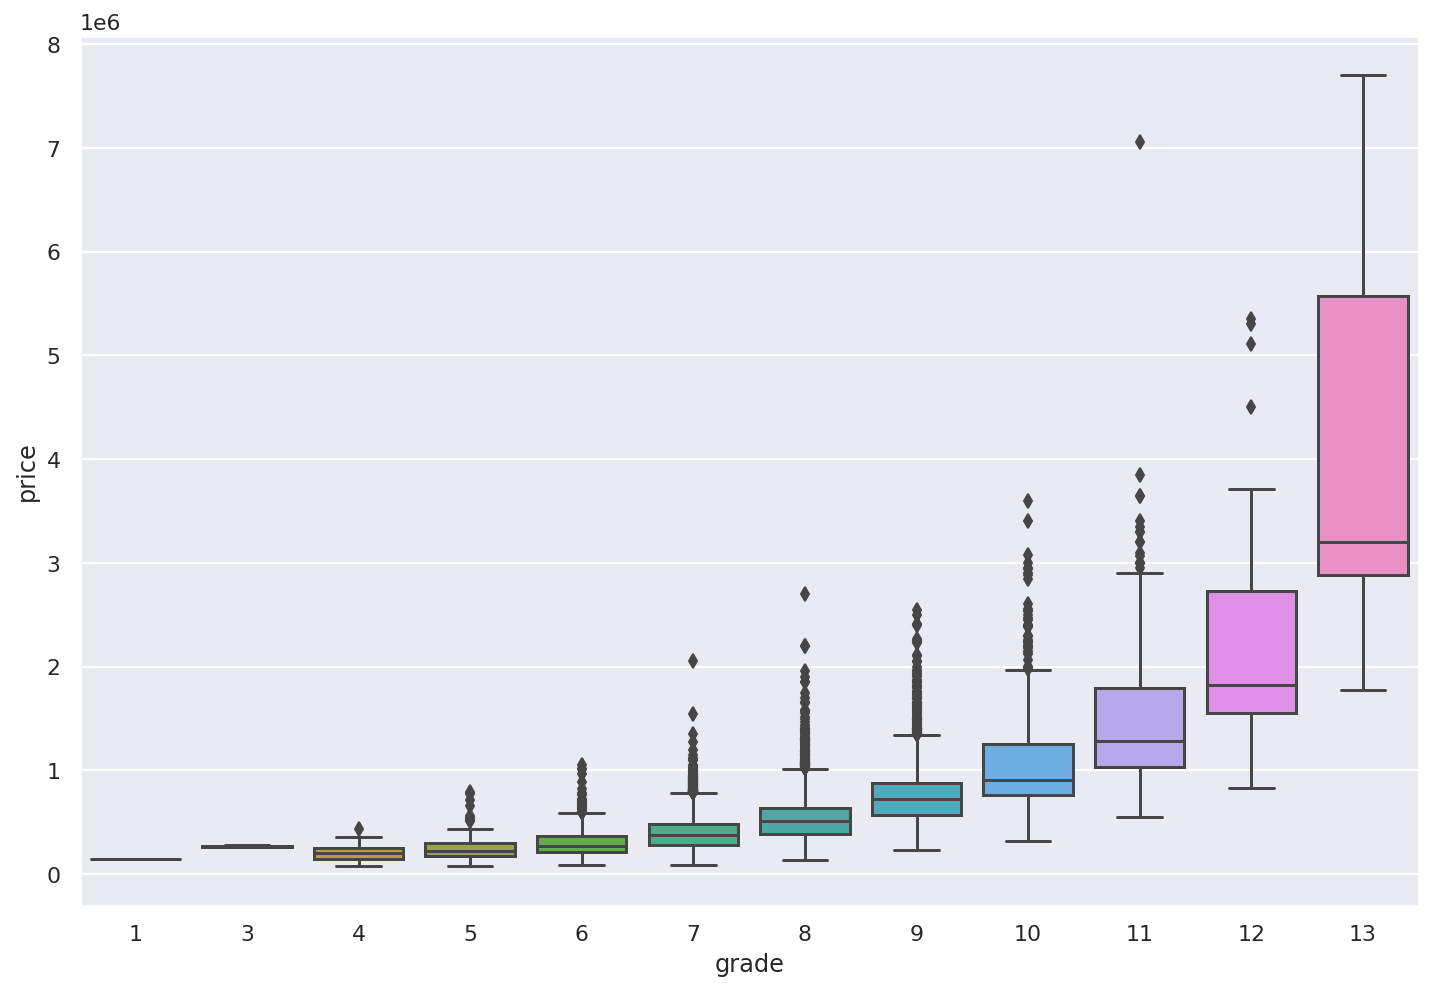

In [7]:
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(x='grade', y='price', data=data)

위의 grade 값을 보았을 때 이상치 값들이 보임, 이상치 처리가 필요함 

- 여러 자료를 보았을 때 경도 위도 값을 이용해서 위치 확인 하는 것을 볼 수 있음
- 나도 한번 따라 확인해봄
- 비싼 집값은 남부보다 북쪽에 더 많이 있는 것을 알 수 있음, 지역적 특성을 몰라서 왜 저 지역이 집값이 비싼지 모르겠음, 우리나라 같은 경우 교통, 특히 학군 등 여러 변수로 인해 그 위치의 집값이 비싼 경우가 많은데 이 데이터는 외국이라서 왜 비싼지는 모름

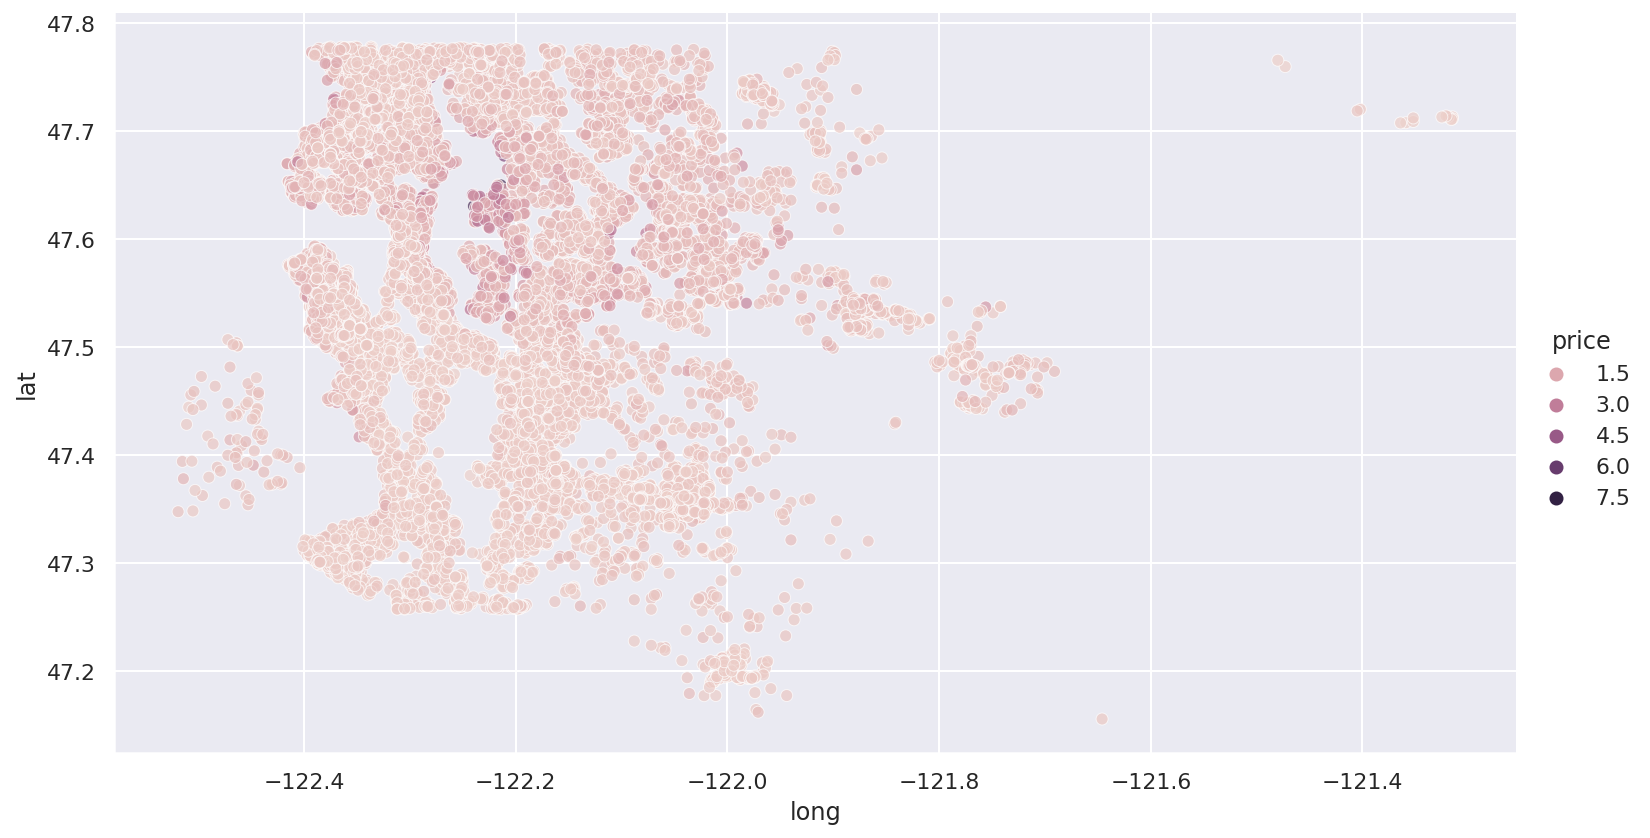

In [8]:
sns.relplot(x = 'long', y = 'lat', hue = 'price', alpha = 0.7, height = 6, aspect = 1.8, data = data)

In [9]:
# 학습데이터에서 라벨 제거
y = data['price']
del data['price']

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [10]:
# 학습 데이터와 테스트 데이터 합치기 
train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))

21503


In [11]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


<AxesSubplot:>

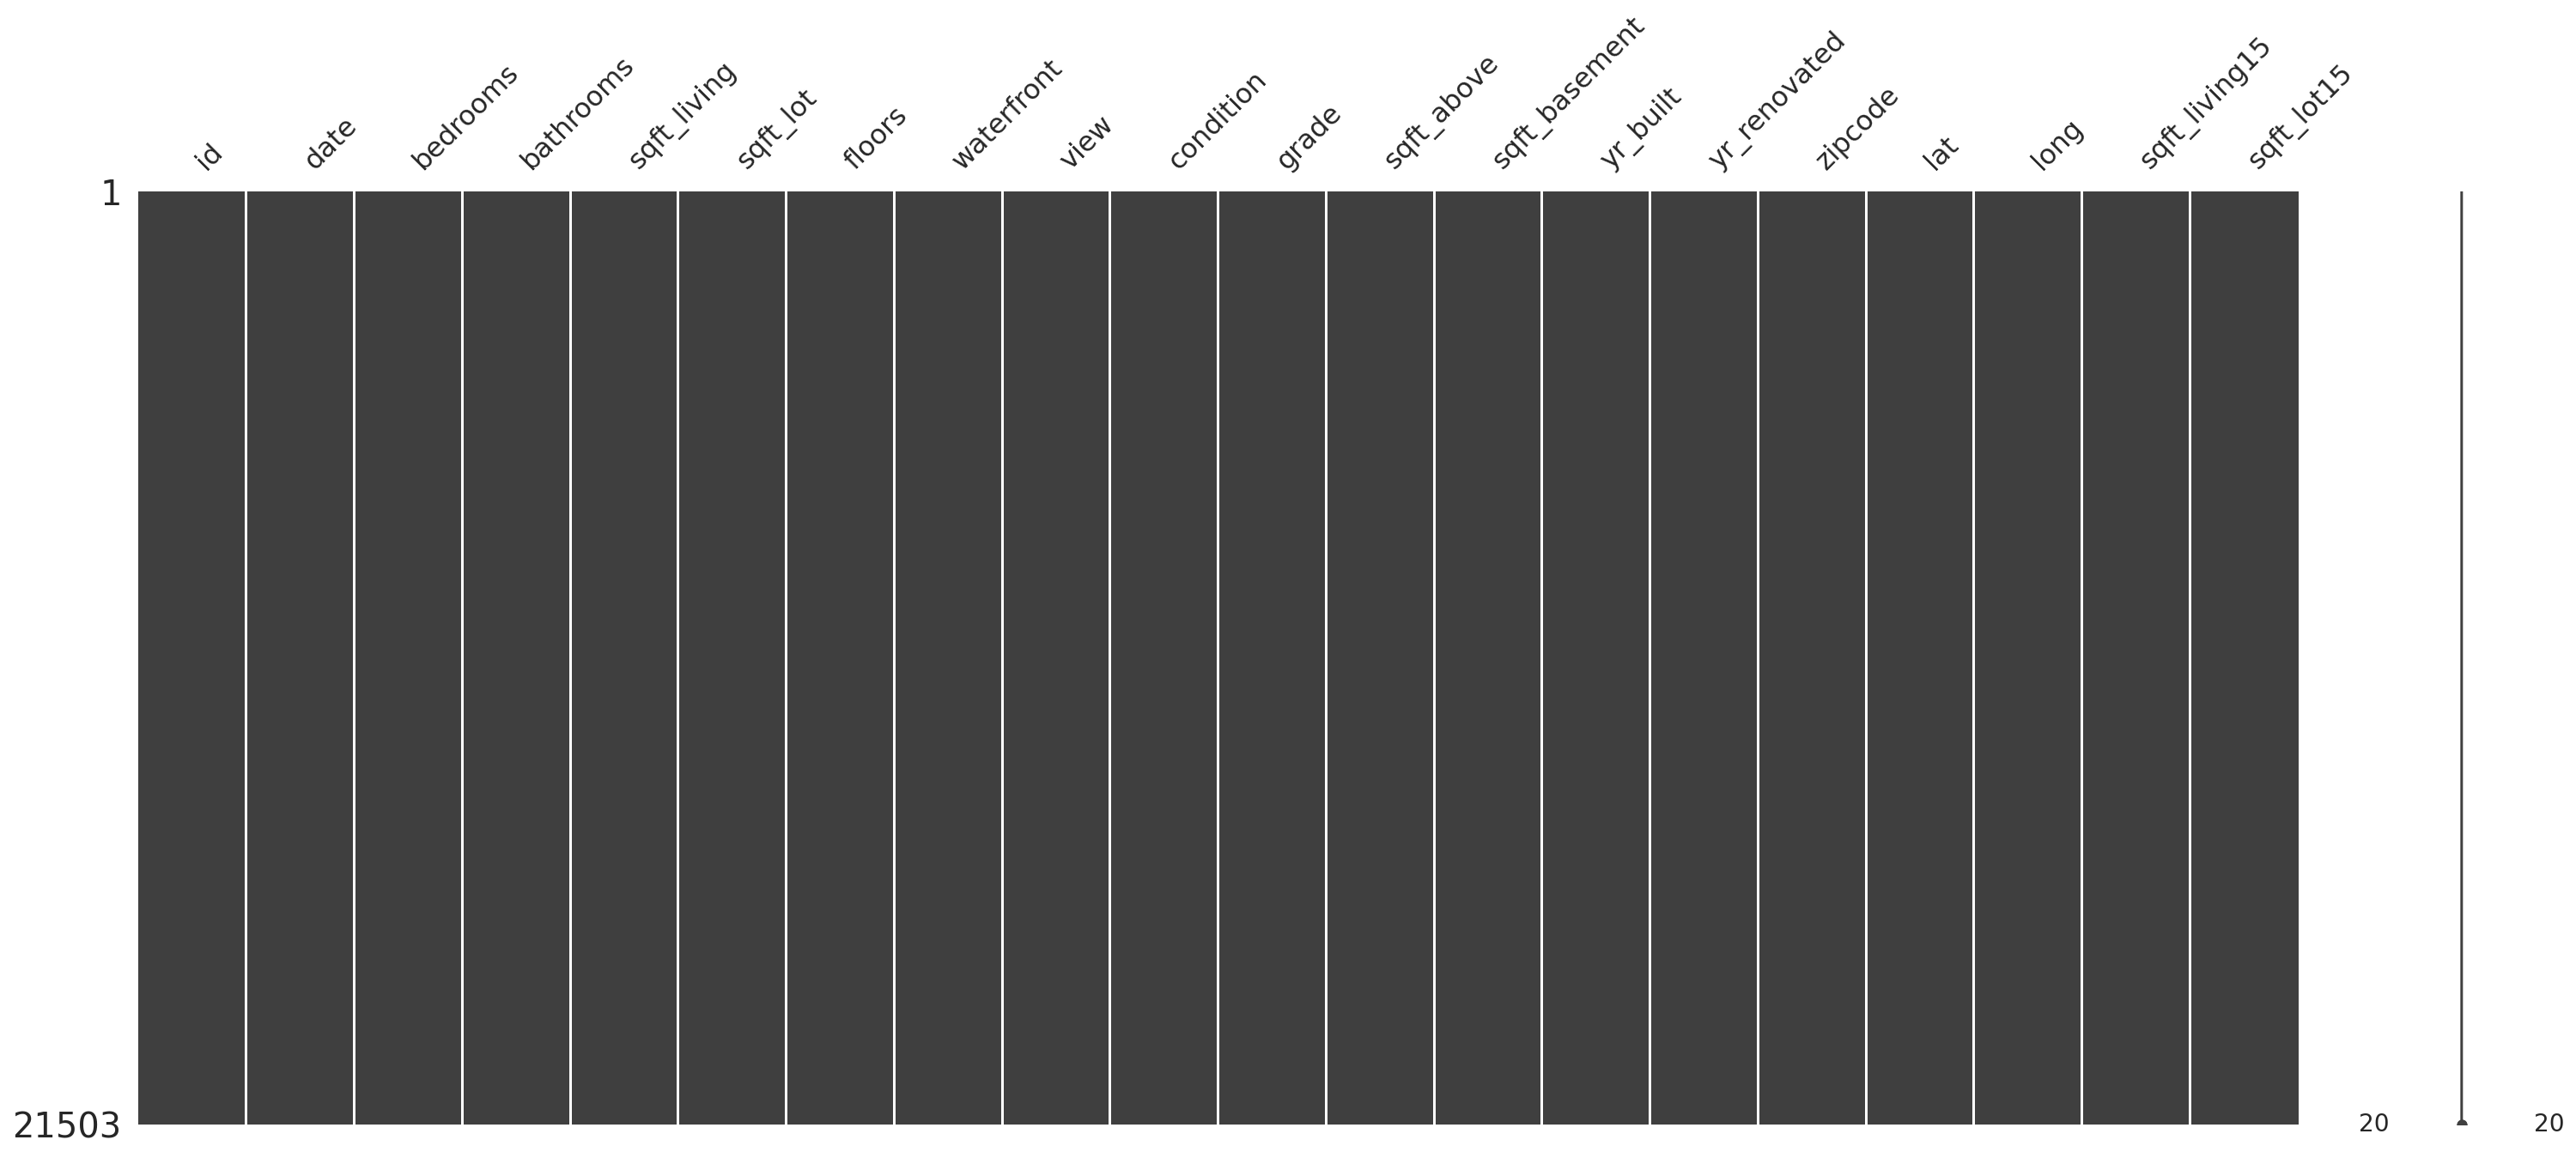

In [12]:
# 결측치 확인하기 
msno.matrix(data)

In [13]:
# 모든 컬럼의 결측치 확인하기 
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [14]:
# id 컬럼 제거 
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [15]:
# date 연월 데이터만 사용하기 위해 자르기 
data['date'] = data['date'].apply(lambda x : str(x[:6]))

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


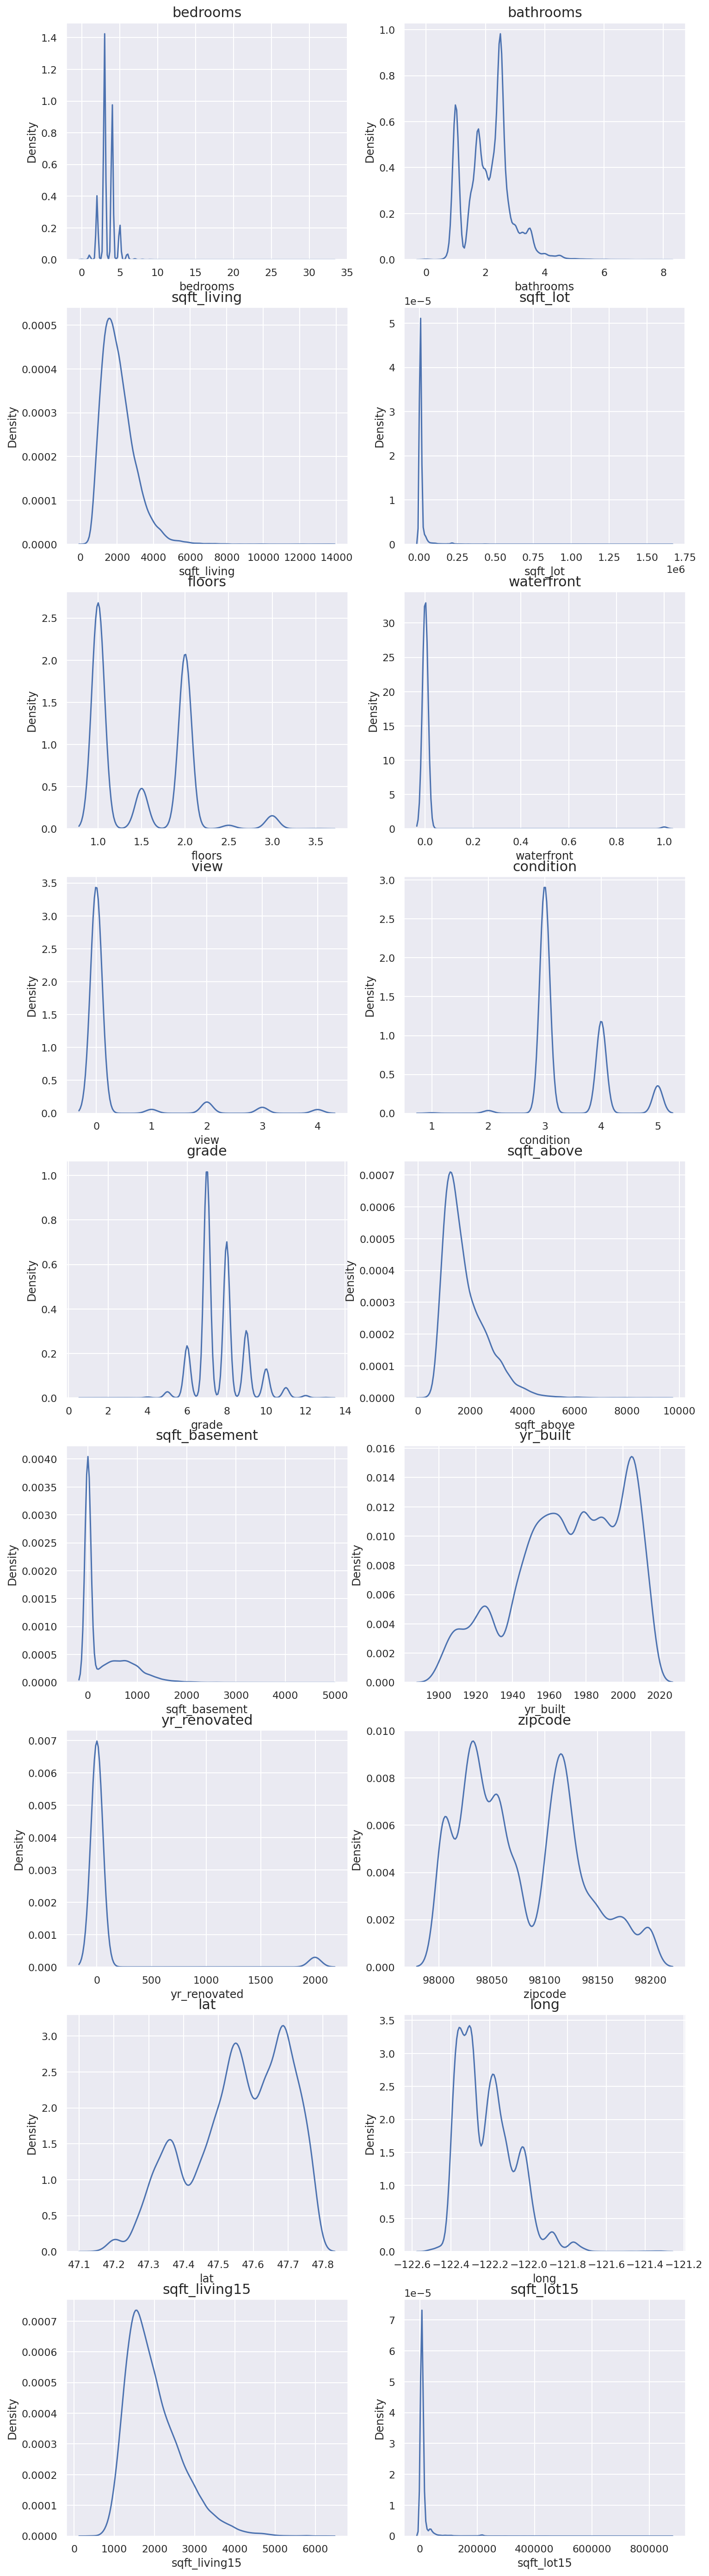

In [16]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

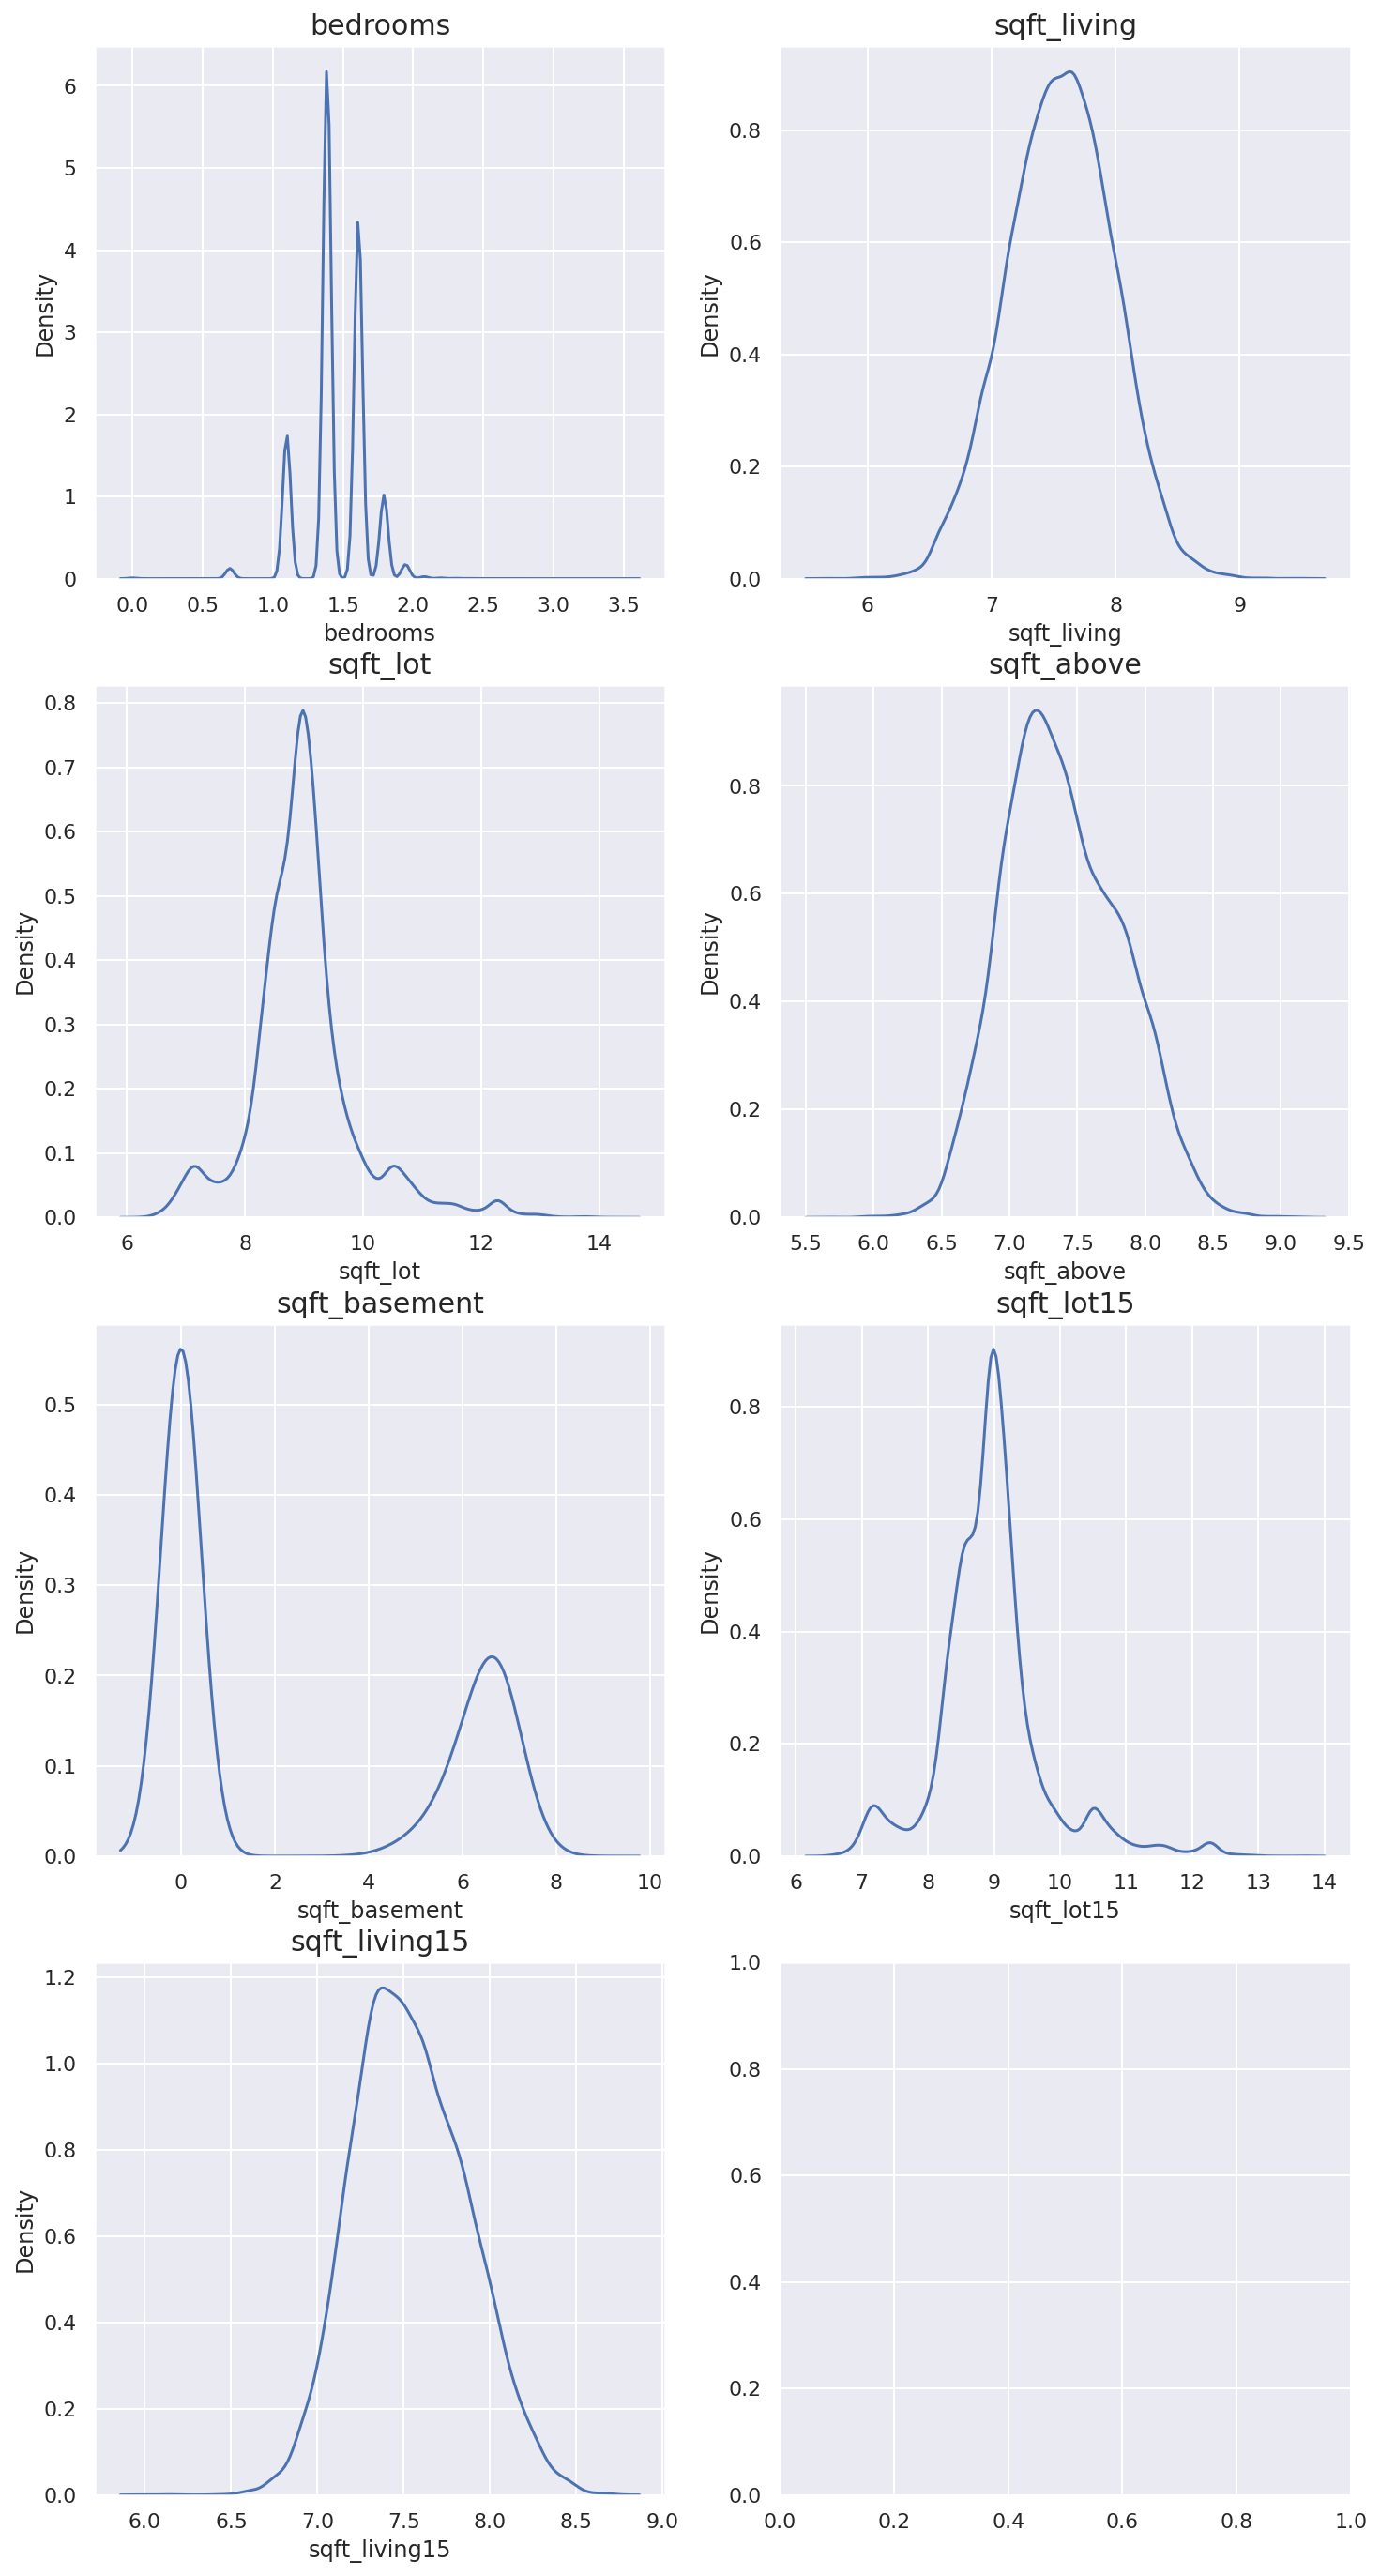

In [17]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

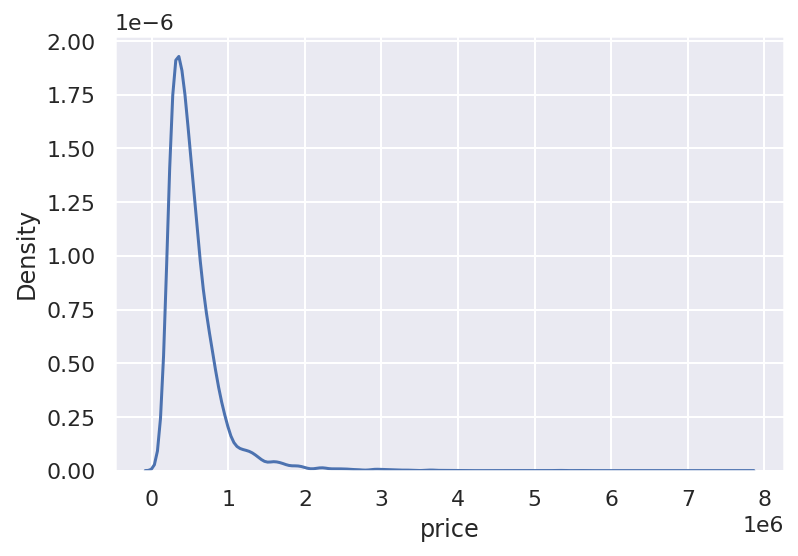

In [18]:
sns.kdeplot(y)
plt.show()

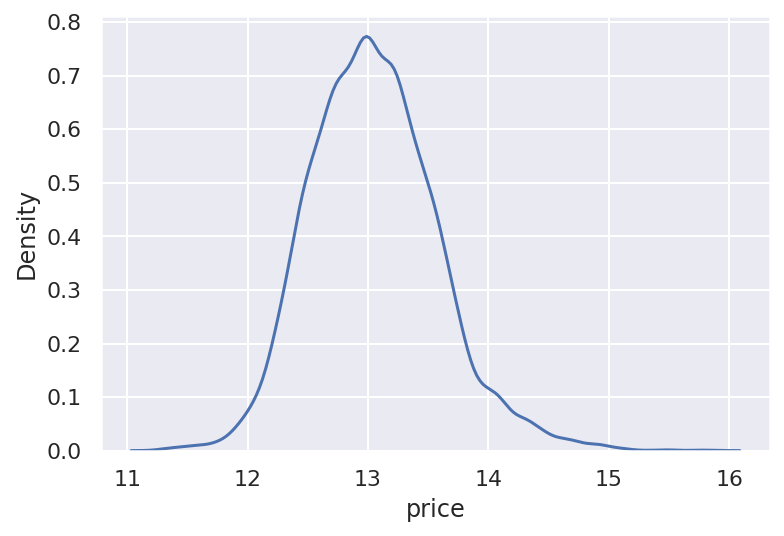

In [19]:
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

In [20]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


## Average Blending

In [21]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

## Cross Validation

In [22]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

In [23]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8598
Model: XGBoost, CV score:0.8860
Model: LightGBM, CV score:0.8819


In [24]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)


In [25]:
# 예측값 생성
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

6468


array([ 529966.66304912,  430726.21272617, 1361676.91242777, ...,
        452081.69137012,  341572.97685942,  421725.1231835 ])

In [26]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [27]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


In [28]:
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission.csv


## 첫번째 score - 120031.23722
![1st](kaggle_kakr_housing/3rd_score.png)

============================================================================================================

# 다시 한번 내 입맛대로 데이터 준비하기

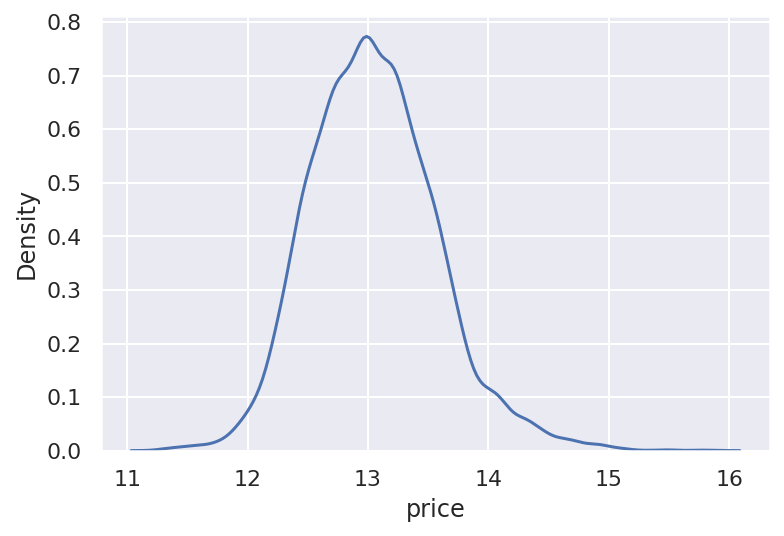

In [29]:
# 데이터 불러오고 전처리
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

y = train['price']
del train['price']

del train['id']

test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

# y 치우친거 제대로
y = np.log1p(y)
sns.kdeplot(y)
plt.show()


In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [31]:
# 필요 라이브러리 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [32]:
# rmse 계산하기 위한 함수 
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [33]:
# 모델 가져오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [34]:
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]


In [35]:
# 4가지 모델에 대한 RMSE 값 빠르게 얻는 함수 
def get_scores(models, train, y):
    df = {}
    
    for model in models :
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y,
                                                            random_state = random_state,
                                                            test_size = 0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending = False)
    
    return score_df

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359
XGBRegressor,110318.669566


In [36]:
# 그리드 탐색 활용
from sklearn.model_selection import GridSearchCV

In [37]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}


In [38]:
model = LGBMRegressor(random_state=random_state)

In [39]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [40]:
grid_model.cv_results_

{'mean_fit_time': array([0.15550451, 0.23275352, 0.46289287, 0.50663767]),
 'std_fit_time': array([0.04825264, 0.07828855, 0.14192696, 0.08456704]),
 'mean_score_time': array([0.01234465, 0.01842055, 0.03493209, 0.04052224]),
 'std_score_time': array([0.00853443, 0.01432623, 0.01788034, 0.01395037]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904

In [41]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [42]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

In [43]:
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


In [44]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [45]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [46]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [47]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [48]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

In [49]:
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

In [50]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [51]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


In [52]:
# csv 저장 경로 및 저장 이름 방법 
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


In [53]:
# 저장 함수 만들기 
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [54]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.164399')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv saved!


## 두번째 score - 115688.17397

====================================================================================================================

In [55]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

y = train['price']
del train['price']

del train['id']

test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

# y 치우친거 제대로
y = np.log1p(y)

In [56]:
param_grid = {
    'learning_rate' : [0.001, 0.01, 0.05, 0.1],
    'n_estimators': [50, 65, 85, 100],
    'max_depth': [1, 3, 7, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
63,0.100,10,100,-0.027027,0.164399
59,0.100,7,100,-0.027343,0.165356
62,0.100,10,85,-0.027347,0.165369
58,0.100,7,85,-0.027707,0.166453
61,0.100,10,65,-0.028048,0.167475
...,...,...,...,...,...
4,0.001,3,50,-0.260888,0.510772
3,0.001,1,100,-0.262146,0.512002
2,0.001,1,85,-0.264484,0.514280
1,0.001,1,65,-0.267607,0.517308


In [57]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.164399')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv saved!
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.4s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.5s
[CV] END ..learning_rate=0.001, max_depth=1, n_estimators=50; total time=   0.1s
[CV] END ..learning_rate=0.001, max_depth=1, n_estimators=65; total time=   0.2s
[CV] END ..learning_rate=0.001, max_depth=1, n_estimators=85; total time=   0.2s
[CV] END .learning_rate=0.001, max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.001, max_depth=3, n_estimators=50; total time=   0.2s
[CV] END ..learning_rate=0.001, max_depth=3, n_estimators=50; total time=   0.2s
[CV] END ..learning_rate=0.001, max_depth=3, n_estimators=85; total time=   0.3s
[CV] END ..learning_rate=0.

## 세번째 score 113112.14053

====================================================================================

# 회고 
- #### 이번 노드는 그냥 말그대로 무작정 그냥!! 따라하는 노드로 진행하였음
- 처음엔 점수가 잘 나온 캐글 노트북을 완전히 쭉 따라가려고 하였지만 코드 작성 방법은 사람들마다 스타일이 너무 달라서 일단 노드에서 했던 내용을 처음부터 끝까지 쭉 따라해봄
- 그리고 중간 중간에 캐글에서 사람들이 많이 썼던 데이터 확인용 그래프들을 써보면서 나도 데이터가 어떻게 생겼는지 확인해봄
- 이런 확인을 통해 이상치들을 확인해볼 수 있었고 데이터에 대해 좀 더 깊게 고민할 수 있었다. 이 값이 필요한건지, 아니면 이걸 좀 더 수정해서 다르게 해야하는지 등 
- 이전 노드에서는 하이퍼파라미터 튜닝의 중요성을 알아보는거였다면 이번 노드는 피처 엔지니어링이 중요하다는 생각이 들었다. 하지만 아쉽게도 하이퍼파라미터 튜닝은 그리드 탐색을 하면서 시도해보았지만 피처 엔지니어링은 시도해보지 못했다. 컬럼을 보면서 값을 수정, 삭제하거나 새로운 컬럼을 추가하면서 여러 가지 변화를 주어야 하는데 그 부분을 하지 못했다. 
- XGBRegressor 모델도 그리드 탐색을 통해 하이퍼파라미터를 찾아보고 싶었는데 돌렸을 때 계속 * 표시만 뜨고 완료가 되지 않아서 결국 그 모델로는 결과값을 도출할 수 없었다. 
- 이번에 우수 프로젝트 올라온 동기님들 노트북을 참고해서 공부해봐야겠다는 생각이 들었다. 
